In [105]:
!pip install requests beautifulsoup4 nltk textblob wordcloud scikit-learn imbalanced-learn pandas matplotlib seaborn


In [106]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
import pandas as pd
from textblob import TextBlob
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import joblib
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [107]:
url = "https://en.wikipedia.org/wiki/austria"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
text = soup.get_text()

In [108]:
text = re.sub(r'\n+', ' ', text)
text = re.sub(r'\[\d+\]', '', text)
text = re.sub(r'[^a-zA-Z. ]', '', text)
text = re.sub(r'\s+', ' ', text).strip()

In [109]:
sentences = sent_tokenize(text)

In [110]:
def analyze_sentiment(sentence):
    return TextBlob(sentence).sentiment.polarity
df = pd.DataFrame(sentences, columns=["sentence"])
df["sentiment_score"] = df["sentence"].apply(analyze_sentiment)
df["sentiment"] = df["sentiment_score"].apply(lambda x: "positive" if x > 0 else ("negative" if x < 0 else "neutral"))


In [111]:
words = word_tokenize(text.lower())
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word.isalpha() and word not in stop_words]


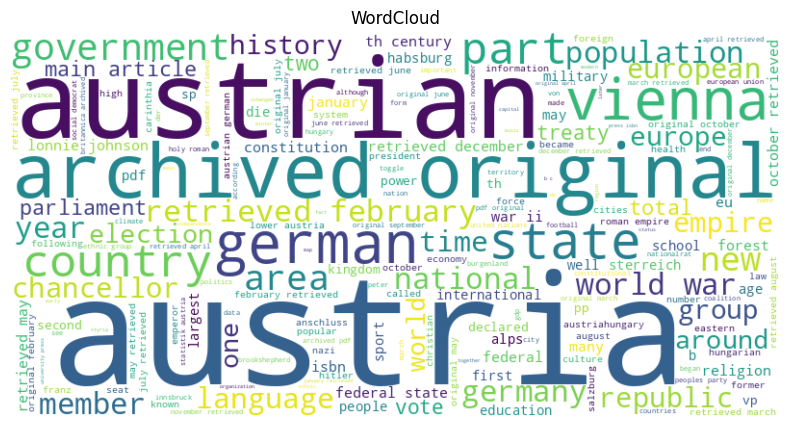

In [112]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud')
plt.show()

In [113]:
from collections import Counter
word_freq = Counter(filtered_words)
print("Top 10 frequent words:", word_freq.most_common(10))

Top 10 frequent words: [('austria', 348), ('austrian', 147), ('retrieved', 147), ('archived', 138), ('original', 132), ('german', 69), ('vienna', 59), ('world', 54), ('may', 51), ('december', 50)]


In [114]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["sentence"])
y = df["sentiment"]

In [115]:
df_binary = df[df["sentiment"] != "neutral"]
X_binary = vectorizer.transform(df_binary["sentence"])
y_binary = df_binary["sentiment"].map({"positive": 1, "negative": 0})  # binary 1=positive, 0=negative


In [116]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_binary, y_binary)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [118]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("🔹 Logistic Regression Report")
print(classification_report(y_test, y_pred_log))


🔹 Logistic Regression Report
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        80
           1       0.97      0.85      0.90        78

    accuracy                           0.91       158
   macro avg       0.92      0.91      0.91       158
weighted avg       0.92      0.91      0.91       158



In [119]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("🔹 Decision Tree Report")
print(classification_report(y_test, y_pred_dt))


🔹 Decision Tree Report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        80
           1       0.88      0.88      0.88        78

    accuracy                           0.89       158
   macro avg       0.89      0.89      0.89       158
weighted avg       0.89      0.89      0.89       158



In [120]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🔹 Random Forest Report")
print(classification_report(y_test, y_pred_rf))


🔹 Random Forest Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        80
           1       0.97      0.96      0.97        78

    accuracy                           0.97       158
   macro avg       0.97      0.97      0.97       158
weighted avg       0.97      0.97      0.97       158



In [121]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("🔹 Gradient Boosting Report")
print(classification_report(y_test, y_pred_gb))


🔹 Gradient Boosting Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        80
           1       0.93      0.96      0.94        78

    accuracy                           0.94       158
   macro avg       0.94      0.94      0.94       158
weighted avg       0.94      0.94      0.94       158



In [122]:
X_train_nb = X_train.copy()
X_train_nb.data = X_train_nb.data.clip(min=0)
X_test_nb = X_test.copy()
X_test_nb.data = X_test_nb.data.clip(min=0)

nb = MultinomialNB()
nb.fit(X_train_nb, y_train)
y_pred_nb = nb.predict(X_test_nb)

print("🔹 Naive Bayes Report")
print(classification_report(y_test, y_pred_nb))


🔹 Naive Bayes Report
              precision    recall  f1-score   support

           0       0.81      0.99      0.89        80
           1       0.98      0.77      0.86        78

    accuracy                           0.88       158
   macro avg       0.90      0.88      0.88       158
weighted avg       0.90      0.88      0.88       158



In [123]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("🔹 KNN Report")
print(classification_report(y_test, y_pred_knn))


🔹 KNN Report
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        80
           1       1.00      0.36      0.53        78

    accuracy                           0.68       158
   macro avg       0.81      0.68      0.65       158
weighted avg       0.81      0.68      0.65       158



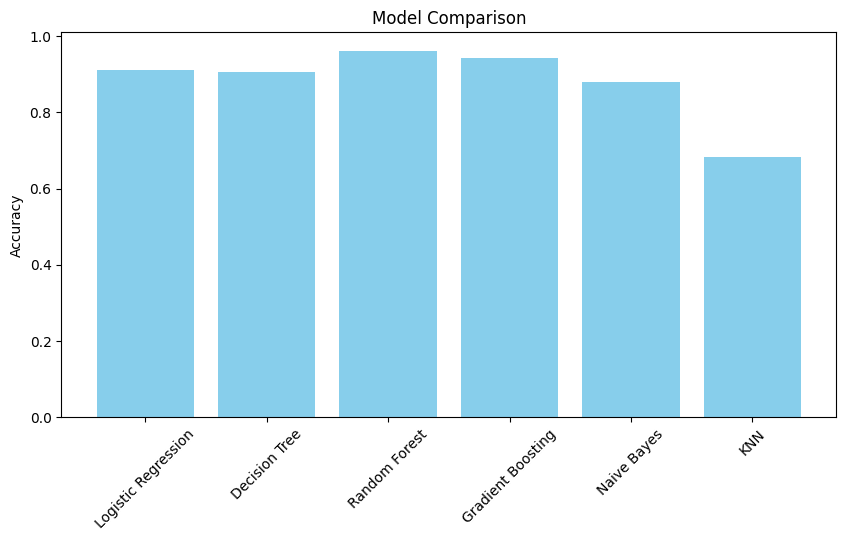

In [124]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Create the 'models' dictionary to store the trained models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),  # Assuming log_reg is already trained
    "Decision Tree": DecisionTreeClassifier(),                # Assuming dt is already trained
    "Random Forest": RandomForestClassifier(),              # Assuming rf is already trained
    "Gradient Boosting": GradientBoostingClassifier(),        # Assuming gb is already trained
    "Naive Bayes": MultinomialNB(),                          # Assuming nb is already trained
    "KNN": KNeighborsClassifier()                           # Assuming knn is already trained
}

plt.figure(figsize=(10, 5))
plt.bar(models_accuracy.keys(), models_accuracy.values(), color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()


In [125]:
final_model = models["Random Forest"]
# Fit model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Save only AFTER fitting
import joblib
joblib.dump(rf, "random_forest_sentiment_model.pkl")  # ✅ trained model
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("\n✅ Random Forest model and vectorizer saved as 'random_forest_sentiment_model.pkl' and 'tfidf_vectorizer.pkl'")



✅ Random Forest model and vectorizer saved as 'random_forest_sentiment_model.pkl' and 'tfidf_vectorizer.pkl'


In [126]:
!pip install -r requirements.txt
!streamlit run app.py


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
/bin/bash: line 1: streamlit: command not found
